In [1]:
#!pip install geopandas
#!pip install mapclassify
#!pip install termcolor

In [2]:
# Super Market Management System
from mysql.connector import connect, Error
from getpass import getpass
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from termcolor import colored
from IPython.display import display, Image


import warnings
warnings.filterwarnings('ignore')

In [3]:
# for text bold
b_s = "\033[1m" # to start bold characters
b_e = "\033[0;0m" # to end bold characters

Enter password········


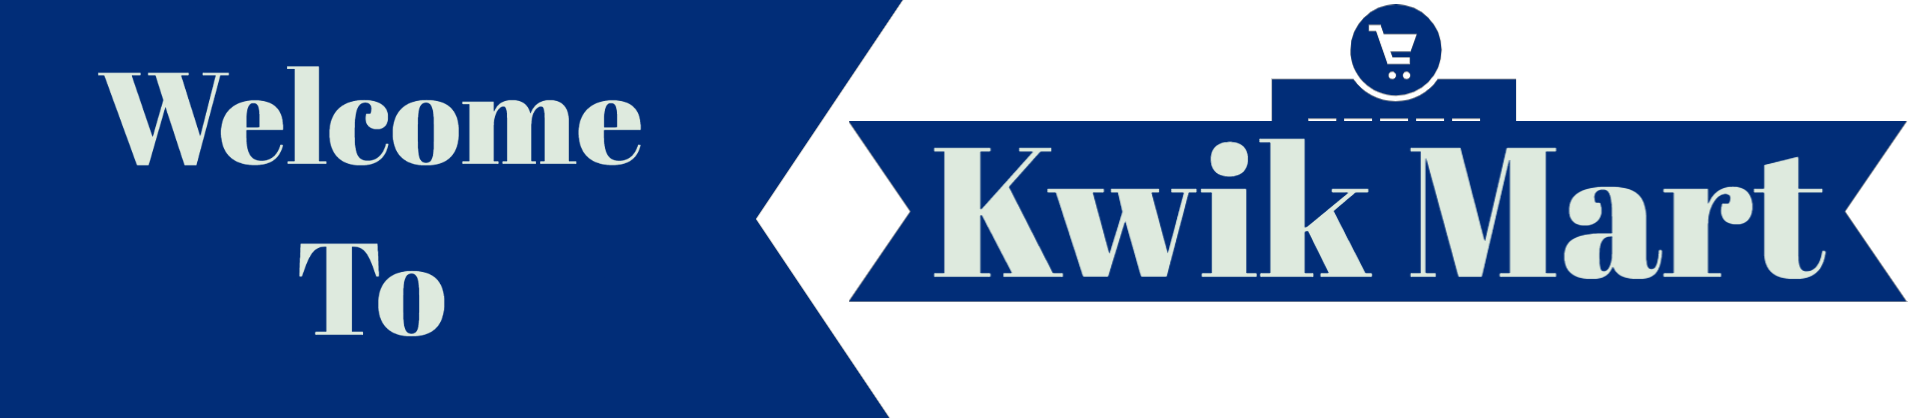

In [4]:
# establishing the connection
try:
        conn = connect(
            host='localhost',
            user='root',
            password=getpass(b_s+'Enter password'+b_e),
            database='kwikmart'
        );
        display(Image(filename='Kwik Mart banner.png'))
except Error as e:
        print(e)

## Some data trends at Kwik Mart

### Looking at the category wise revenue across all stores

In [5]:
def getCategoriesRevenue(conn, start_date, end_date):
    query='''
    SELECT c.category_name AS Category_Name ,SUM(bi.quantity * bi.net_price) AS Revenue
    FROM bill b
    JOIN bill_items bi ON bi.bill_id = b.bill_id
        AND b.bill_date >= %s and b.bill_date <= %s
    JOIN item i ON i.item_id = bi.item_id
    JOIN category c ON c.category_id = i.category_id
    GROUP BY Category_Name
    ORDER BY Revenue DESC
    ''';
    
    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            amt = '$'+str(math.trunc(y[i]))
            plt.text(i, y[i]//4, amt, ha = 'center',
                     bbox = dict(facecolor = 'white', alpha =.8),
                    rotation = 90)
        
    value_tuple=(start_date, end_date);
    df = pd.read_sql(query, conn, params=[start_date, end_date])
    plt.figure(figsize=(15, 5))
    plt.bar(df.Category_Name, df.Revenue)
    plt.xticks(rotation=90)
    
    addlabels(df.Category_Name, df.Revenue)
    
    # Add labels and a title.
    plt.xlabel('Categories', labelpad=10, color='#333333',weight='bold')
    plt.ylabel('Net Revenue', labelpad=10, color='#333333',weight='bold')
    plt.title(f'Category wise revenue between [{start_date} , {end_date}]', pad=15, color='#333333',weight='bold')

    plt.show()

Category wise sales across all stores, please enter the date range:
From date: 2022-01-01
Till date: 2022-12-31


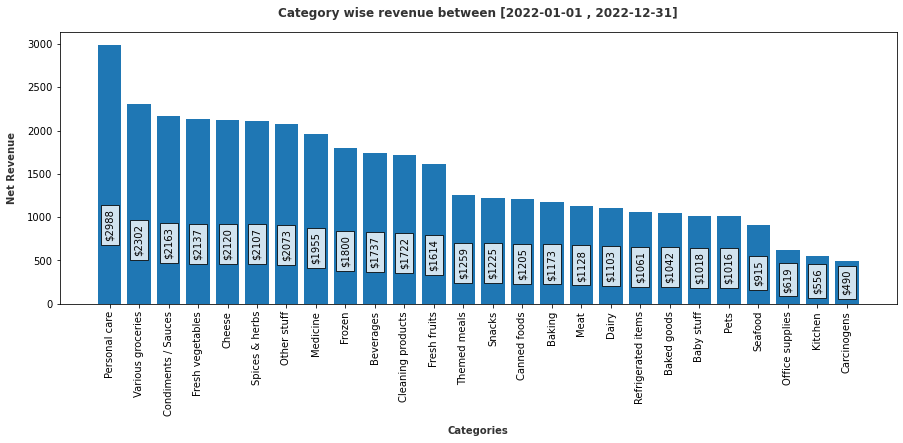

In [6]:
# calling getCategoriesRevenue function
print(b_s+"Category wise sales across all stores, please enter the date range:"+b_e)
cat_rev_start = input(b_s+"From date: "+b_e)
cat_rev_end = input(b_s+"Till date: "+b_e)
getCategoriesRevenue(conn, cat_rev_start, cat_rev_end)
#2022-01-01 | 2022-12-31

### State wise no of stores and revenue 

In [7]:
def numOfstoresVsRevenue(conn):
    query1 = '''
    Select t1.state, t1.numOfStores, t2.revenue from
    (select count(*) as numOfStores, store.state
    from store
    group by store.state
    order by store.state) t1 join 
    (    select store.state, SUM(revenue) as revenue
    from store left outer join (
    select bill.store_id, Sum(bill_items.quantity * bill_items.net_price) as revenue
    from bill, bill_items
    where bill.bill_id = bill_items.bill_id
    group by bill.store_id) temp
    on store.store_id = temp.store_id
    group by store.state) t2
    where t2.state = t1.state
    order by t1.numOfStores
    ''';
    
    df = pd.read_sql(query1, conn);
    return df

In [8]:
# calling function
df = numOfstoresVsRevenue(conn)
df.rename(columns={"state": "NAME"},inplace=True)
di = {"SouthDakota":"South Dakota", "WestVirginia":"West Virginia", "RhodeIsland":"Rhode Island", "NewHampshire":"New Hampshire", 
                "NewMexico":"New Mexico", "NorthDakota": "North Dakota","NewJersey":"New Jersey"}
df = df.replace({"NAME": di})

# getting latitude and longitude for each state
df_lat_long = pd.read_csv("US_States_lat_lon_final.csv")
df_states = df_lat_long.merge(df,on='NAME',how='outer')
df_states[["numOfStores","revenue"]] = df_states[["numOfStores","revenue"]].fillna(0)
df_states.head()

,NAME,lat,lon,numOfStores,revenue
0,Maryland,39.045753,-76.641273,3.0,1726.23
1,Iowa,42.032974,-93.581543,2.0,108.63
2,Delaware,39.000000,-75.500000,5.0,930.27
3,Ohio,40.367474,-82.996216,3.0,2491.55
4,Pennsylvania,41.203323,-77.194527,3.0,1019.02


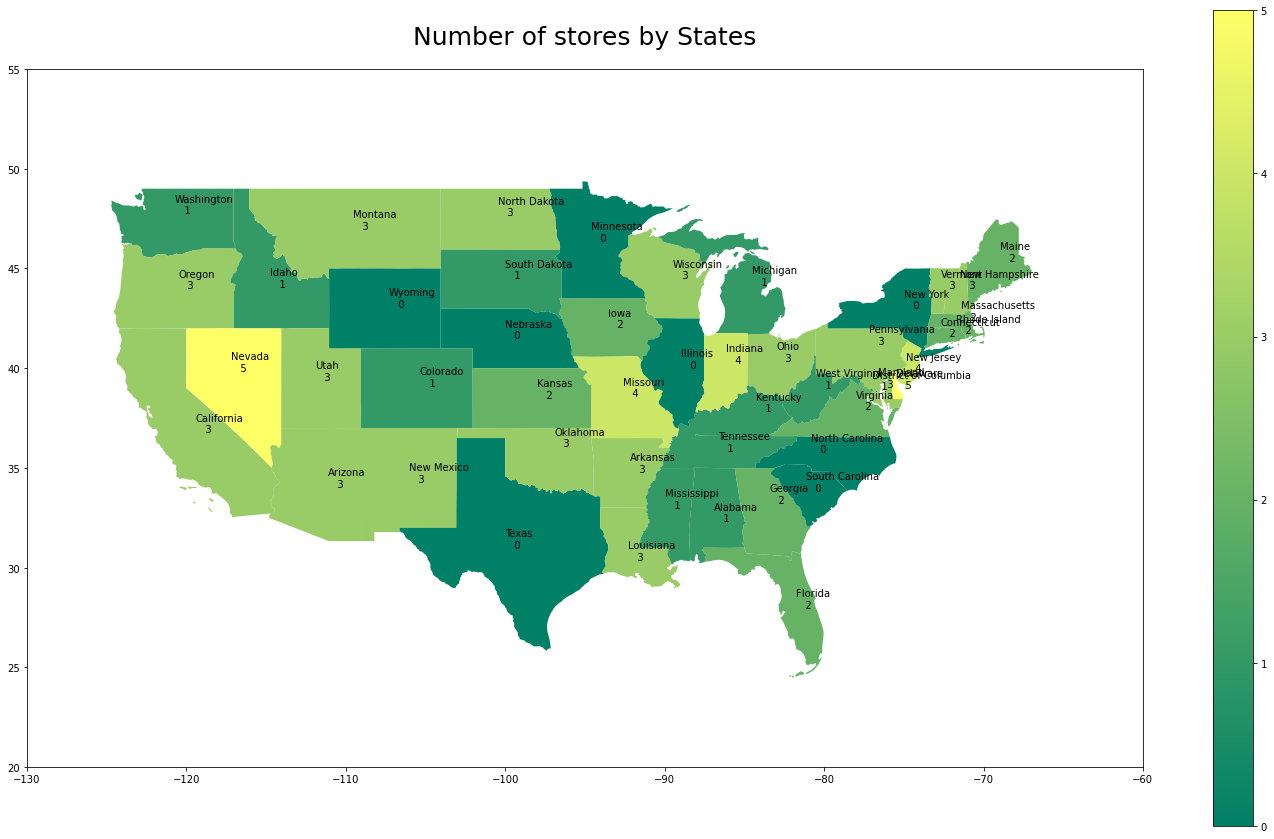

In [9]:
# url of our shape file 
path=r"C:\Users\agraw\Documents\Git\DS5110\Python implementation\cb_2018_us_state_20m"
# load the shape file using geopandas
geo_usa = gpd.read_file(path+'\cb_2018_us_state_20m.shp')

# merge usa_state data and geo_usa shapefile
geo_merge=geo_usa.merge(df_states,on='NAME',how='outer')

indexRow = geo_merge[ (geo_merge.NAME == 'Alaska') | (geo_merge.NAME == 'Hawaii') | (geo_merge.NAME == 'Puerto Rico')].index
geo_merge.drop(indexRow , inplace=True)
geo_merge.reset_index(drop=True, inplace=True)

# plot state wise number of stores
geo_merge.plot(column='numOfStores', figsize=(25, 15),legend=True,cmap='summer')
plt.xlim(-130,-60)
plt.ylim(20,55)
# add countries names and numbers 
for i in range(len(geo_merge)):
    plt.text(geo_merge.lon[i],geo_merge.lat[i],"{}\n   {}".format(geo_merge.NAME[i],int(geo_merge.numOfStores[i])),size=10)
plt.title('Number of stores by States',pad=25,fontsize=25)
plt.show()

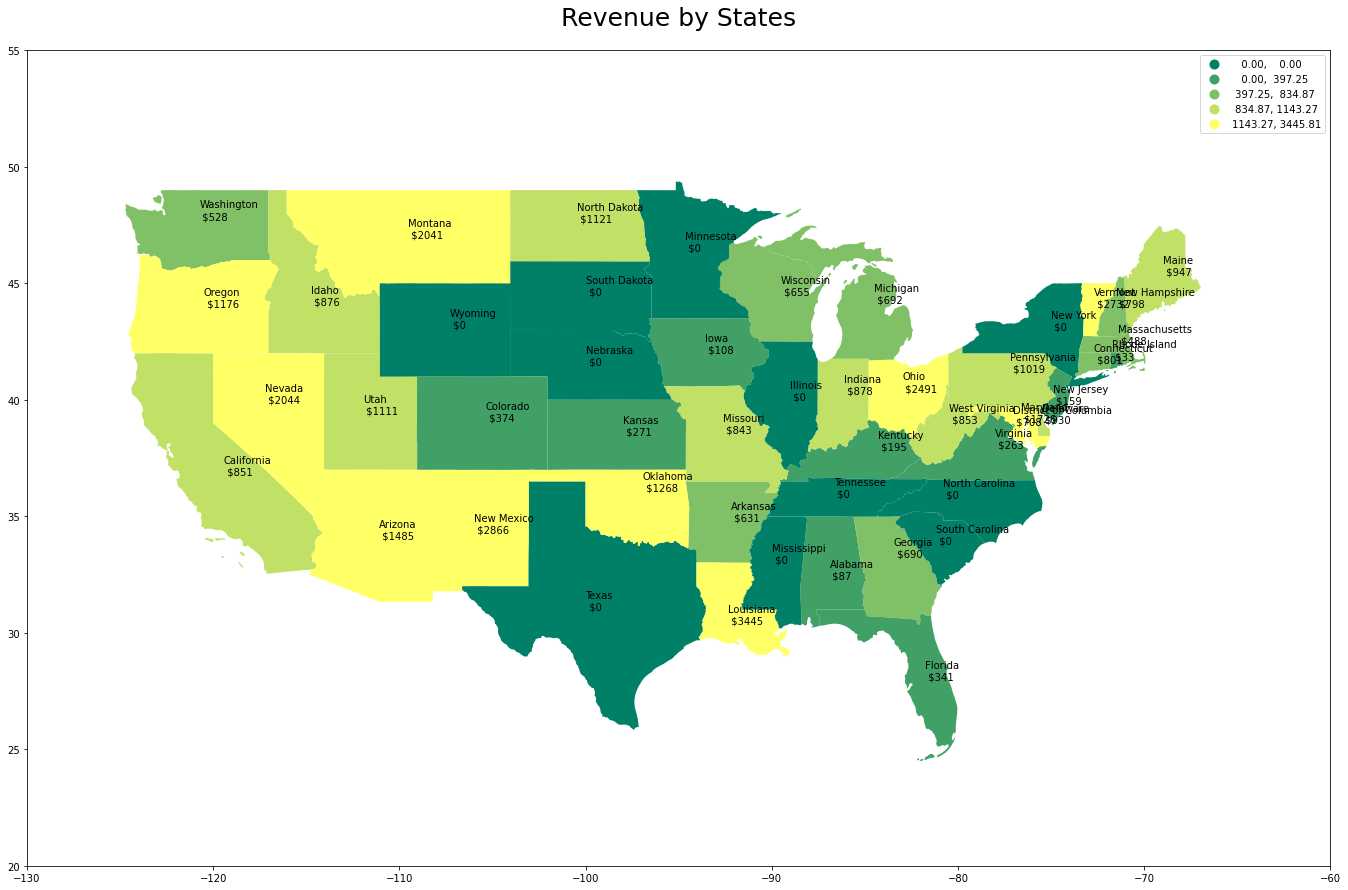

In [10]:
# plot state wise revenue
geo_merge.plot(column='revenue',scheme="quantiles", figsize=(25, 15),legend=True,cmap='summer')
plt.xlim(-130,-60)
plt.ylim(20,55)
# add countries names and numbers 
for i in range(len(geo_merge)):
    plt.text(geo_merge.lon[i],geo_merge.lat[i],\
             "\n{}\n ${}".format(geo_merge.NAME[i],int(geo_merge.revenue[i])),size=10)
plt.title('Revenue by States',pad=25,fontsize=25)
plt.show()

### Quarter-wise business performance based on Revenue

In [11]:
def revenueInEachQuarter(conn, year):
    query='''
    SELECT CEILING(MONTH(b.bill_date)/3) AS quarter, SUM(bi.net_price*bi.quantity) net_revenue
    FROM bill_items bi
    JOIN bill b ON b.bill_id = bi.bill_id
    WHERE b.bill_date LIKE %s
    GROUP BY 1
    ORDER BY quarter
    ''';
    
    value_tuple = (year+'%',)
    df = pd.read_sql(query, conn,params = value_tuple)
    idx = df[['net_revenue']].idxmax()
    myexplode = np.zeros(len(df.quarter))
    myexplode[idx[0]] = 0.1
    
    plt.figure(figsize=(7, 7))
    plt.pie(df.net_revenue, labels = df.quarter,autopct='%.0f%%', explode = myexplode)
    plt.title(f'Quarterly Revenue for year {year}',pad=10,fontsize=15)

    plt.show()

Quarterly performance, please enter the year: 2022


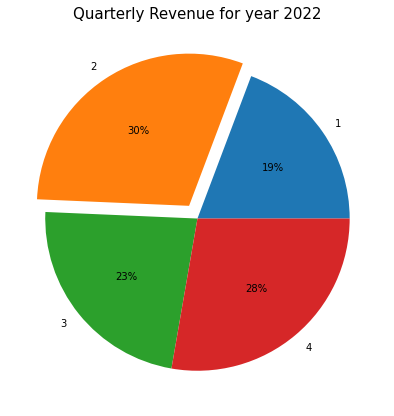

In [12]:
# pie-chart to visulize quarterly performance
qtr_year = input(b_s+"Quarterly performance, please enter the year: "+b_e)
revenueInEachQuarter(conn,qtr_year)

## Working with views, functions and stored procedures

### Views

#### 1) Employee Details: This view has only the basic details of all the active employees across all the stores. All the sensetive informations such as salary, SSN number, and higher level employess (CEO's) information has been hidden.

In [13]:
query='''
    SELECT * FROM kwikmart.employee_details
    ''';
df = pd.read_sql(query, conn)
df

,emp_id,role,store_id,store_address,phone,emp_name,emp_address
0,1,Cleaner,94,"Trantow Passage, West Mateoshire",986-791-7914,Alford Kettridge,87 Springs Pass
1,2,Team Lead,78,"Douglas Underpass, Oberbrunnerstad",398-976-3403,Jaye Dimitriev,52 Spenser Court
2,5,Restock Person,73,"Schmeler Overpass, Karliton",415-445-1792,Caria Atwater,20 Bobwhite Crossing
3,6,Packing Person,35,"Sigurd Prairie, New Arne",545-821-2770,Eugenie Barczewski,20 Ohio Avenue
4,7,Inventory Maintainer,69,"Marielle Spur, North Dawson",774-382-0966,Brnaba Keattch,347 Veith Court
...,...,...,...,...,...,...,...
237,488,Cleaner,48,"Reichel Run, East Horacioview",962-691-1644,Eddie Izhakov,3 Knutson Pass
238,489,County Manager,23,"Collier Underpass, Hodkiewiczbury",178-305-9421,Bev Dalbey,1788 Ryan Plaza
239,490,Board of Directors,58,"Ezra Vista, Nedmouth",437-365-1788,Pedro Rohloff,92497 Elka Terrace
240,495,Cleaner,76,"Sauer Motorway, East Korbinmouth",250-588-7621,Jeanette Sleit,31330 Bobwhite Avenue


#### 2) Current month's store revenue: This view helps the upper management to track the current month's revenue along with the previous day revenue across all the stores. 

In [14]:
query='''
    SELECT * FROM kwikmart.current_month_store_revenue
    ''';
df = pd.read_sql(query, conn)
df

,store_id,store_detail,store_email,net_revenue_till_date,previous_day_revenue,total_bills_till_date
0,20,"Nikko Station , Kemmerfort",93agf@kwikmart.com,755.21,0.0,2
1,48,"Reichel Run , East Horacioview",07brx@kwikmart.com,606.19,0.0,2
2,42,"Zulauf Locks , Lake Dockbury",56gtb@kwikmart.com,579.90,0.0,1
3,16,"Henderson Vista , East Tracefort",12lwm@kwikmart.com,474.38,0.0,2
4,94,"Trantow Passage , West Mateoshire",73cjj@kwikmart.com,415.92,0.0,1
5,9,"Davin Village , New Nova",71zrl@kwikmart.com,316.27,0.0,1
6,21,"D'Amore Pine , Stammhaven",15maw@kwikmart.com,273.65,0.0,1
7,31,"Tremblay Valley , West Dellview",90dtb@kwikmart.com,270.23,0.0,1
8,95,"Vicenta Springs , Prohaskahaven",88ssu@kwikmart.com,217.61,0.0,1
9,27,"Weimann Branch , East Cristinaburgh",21zqc@kwikmart.com,184.42,0.0,1


### Functions

#### 1) Net revenue for a particular store in a given date range: This helps each store track their performance across months or days.

In [15]:
cursor = conn.cursor()

In [16]:
func = "SELECT store_billing(%s, %s, %s)"
store_id = input(b_s+"Please enter store id: ")
start_date = input(b_s+"From date: ")
end_date = input(b_s+"Till date: ")

result = cursor.execute(func, [store_id, start_date, end_date])
print(b_s+f"Total revenue for store id {store_id} between {start_date} and {end_date} is: "+b_e, cursor.fetchone()[0],)

Please enter store id: 1
From date: 2022-01-01
Till date: 2022-12-31
Total revenue for store id 1 between 2022-01-01 and 2022-12-31 is:  853.63


#### 2) Update discount for product: This function let store manager create new discount or update the previous discounts along with an option to make it active or inactive

In [17]:
print(cursor.fetchone())

None


In [18]:
store_id = '1'
start_date = '2022-01-01'
end_date = '2022-12-03'
result = cursor.execute(func, [store_id, start_date, end_date])
print(b_s+f"Total revenue for store id {store_id} between {start_date} and {end_date} is: "+b_e, cursor.fetchone()[0],)

Total revenue for store id 1 between 2022-01-01 and 2022-12-03 is:  853.63
